# Uber Rides Data Analysis using Python

# Package Importing

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('mode.chained_assignment', None)

# Dataset Importing

In [52]:
dataset = pd.read_csv("C:/Users/Tinuanandh/OneDrive/Desktop/UberDataset.csv")
dataset.head()

,START_DATE,END_DATE,CATEGORY,START,STOP,MILES,PURPOSE
0,01-01-2016 21:11,01-01-2016 21:17,Business,Fort Pierce,Fort Pierce,5.1,Meal/Entertain
1,01-02-2016 01:25,01-02-2016 01:37,Business,Fort Pierce,Fort Pierce,5.0,NaN
2,01-02-2016 20:25,01-02-2016 20:38,Business,Fort Pierce,Fort Pierce,4.8,Errand/Supplies
3,01-05-2016 17:31,01-05-2016 17:45,Business,Fort Pierce,Fort Pierce,4.7,Meeting
4,01-06-2016 14:42,01-06-2016 15:49,Business,Fort Pierce,West Palm Beach,63.7,Customer Visit


# Summary statistics

In [33]:
dataset.shape

(1156, 7)

In [34]:
dataset.describe()

,MILES
count,1156.000000
mean,21.115398
std,359.299007
min,0.500000
25%,2.900000
50%,6.000000
75%,10.400000
max,12204.700000


In [35]:
dataset.columns

Index(['START_DATE', 'END_DATE', 'CATEGORY', 'START', 'STOP', 'MILES',
       'PURPOSE'],
      dtype='object')

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   object 
 4   STOP        1155 non-null   object 
 5   MILES       1156 non-null   float64
 6   PURPOSE     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB


In [37]:
dataset.dtypes

START_DATE     object
END_DATE       object
CATEGORY       object
START          object
STOP           object
MILES         float64
PURPOSE        object
dtype: object

In [38]:
print("\
Missing Values:")
print(dataset.isnull().sum())

Missing Values:
START_DATE      0
END_DATE        1
CATEGORY        1
START           1
STOP            1
MILES           0
PURPOSE       503
dtype: int64


# Droping the Duplicate Values

In [53]:
duplicates = dataset[dataset.duplicated()]
print(duplicates)

          START_DATE         END_DATE  CATEGORY   START  STOP  MILES  PURPOSE
492  6/28/2016 23:34  6/28/2016 23:59  Business  Durham  Cary    9.9  Meeting


In [54]:
dataset.drop_duplicates(inplace=True)

In [55]:
duplicates = dataset[dataset.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [START_DATE, END_DATE, CATEGORY, START, STOP, MILES, PURPOSE]
Index: []


# Data Transformation

In [56]:
dataset['PURPOSE'] = dataset['PURPOSE'].fillna("NOT")
print("\
Missing Values:")
print(dataset.isnull().sum())

Missing Values:
START_DATE    0
END_DATE      1
CATEGORY      1
START         1
STOP          1
MILES         0
PURPOSE       0
dtype: int64


In [57]:
from datetime import datetime
import pandas as pd
print("Dataset before conversion:")
print(dataset.head())
dataset['START_DATE'] = pd.to_datetime(dataset['START_DATE'], errors='coerce')
dataset['END_DATE'] = pd.to_datetime(dataset['END_DATE'], errors='coerce')
dataset['date'] = pd.DatetimeIndex(dataset['START_DATE']).date
dataset['time'] = pd.DatetimeIndex(dataset['START_DATE']).hour
dataset['day-night'] = pd.cut(
    x=dataset['time'],
    bins=[0, 10, 15, 19, 24],
    labels=['Morning', 'Afternoon', 'Evening', 'Night']
)

dataset['DURATION'] = (dataset['END_DATE'] - dataset['START_DATE']).dt.total_seconds() / 60
print("\nDataset After conversion:")
print(dataset.head())


Dataset before conversion:
         START_DATE          END_DATE  CATEGORY        START             STOP  \
0  01-01-2016 21:11  01-01-2016 21:17  Business  Fort Pierce      Fort Pierce   
1  01-02-2016 01:25  01-02-2016 01:37  Business  Fort Pierce      Fort Pierce   
2  01-02-2016 20:25  01-02-2016 20:38  Business  Fort Pierce      Fort Pierce   
3  01-05-2016 17:31  01-05-2016 17:45  Business  Fort Pierce      Fort Pierce   
4  01-06-2016 14:42  01-06-2016 15:49  Business  Fort Pierce  West Palm Beach   

   MILES          PURPOSE  
0    5.1   Meal/Entertain  
1    5.0              NOT  
2    4.8  Errand/Supplies  
3    4.7          Meeting  
4   63.7   Customer Visit  

Dataset After conversion:
           START_DATE            END_DATE  CATEGORY        START  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:31:

# Outlier Detection

In [45]:
def detect_outliers(df, columns):
    outliers = np.zeros(len(df))
    for column in columns:
        z_scores = np.abs((dataset[column] - dataset[column].mean()) / dataset[column].std())
        outliers += (z_scores > 3).astype(int)
    return outliers > 0
outlier_columns = ['MILES', 'DURATION']
outliers = detect_outliers(dataset, outlier_columns)
print(outliers)

0       False
1       False
2       False
3       False
4       False
        ...  
1151    False
1152    False
1153    False
1154    False
1155     True
Name: MILES, Length: 1155, dtype: bool


# Outlier Handling

In [46]:
df_clean = dataset[~outliers]

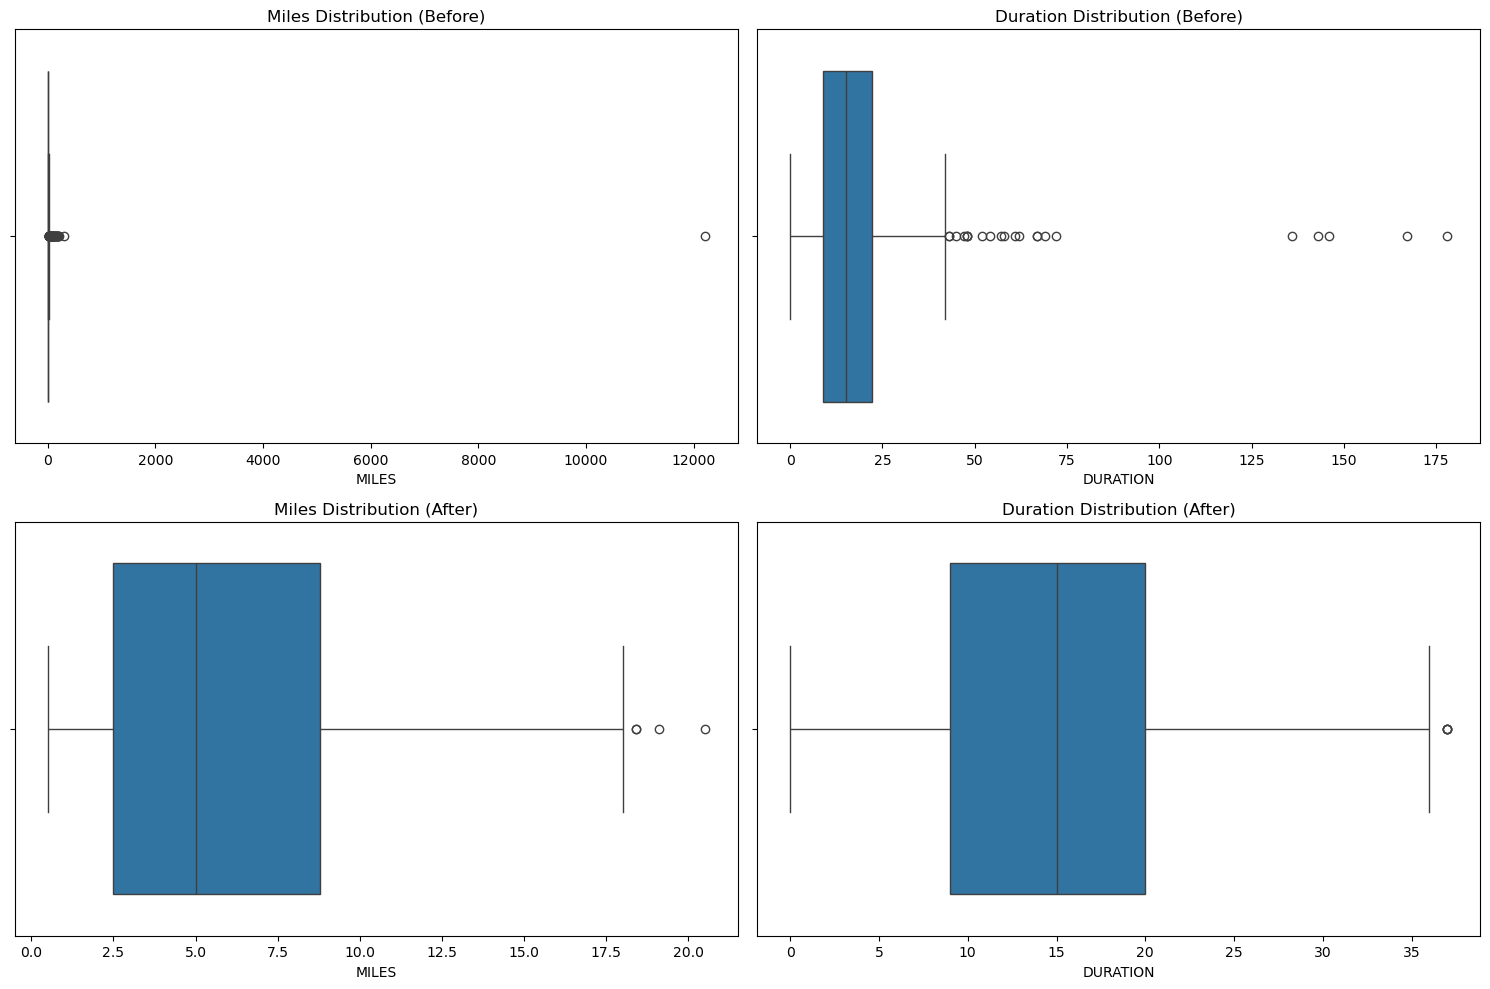

In [47]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df_clean = remove_outliers(dataset, 'MILES')
df_clean = remove_outliers(df_clean, 'DURATION')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x=dataset['MILES'], ax=axes[0, 0])
axes[0, 0].set_title('Miles Distribution (Before)')
sns.boxplot(x=dataset['DURATION'], ax=axes[0, 1])
axes[0, 1].set_title('Duration Distribution (Before)')
sns.boxplot(x=df_clean['MILES'], ax=axes[1, 0])
axes[1, 0].set_title('Miles Distribution (After)')
sns.boxplot(x=df_clean['DURATION'], ax=axes[1, 1])
axes[1, 1].set_title('Duration Distribution (After)')
plt.tight_layout()
plt.show()


# Descripitve Analysis

In [49]:
descriptive_stats = dataset.describe()
descriptive_stats

,START_DATE,END_DATE,MILES,time,DURATION
count,421,420,1155.000000,421.000000,420.000000
mean,2016-07-01 12:31:09.976247040,2016-07-01 12:11:10.142857216,21.125108,14.988124,19.326190
min,2016-01-01 21:11:00,2016-01-01 21:17:00,0.500000,0.000000,0.000000
25%,2016-04-01 13:43:00,2016-03-27 15:10:00,2.900000,12.000000,9.000000
50%,2016-07-04 18:23:00,2016-07-04 18:19:00,6.000000,15.000000,15.000000
75%,2016-10-10 17:22:00,2016-10-10 17:39:15,10.400000,18.000000,22.250000
max,2016-12-12 20:48:00,2016-12-12 20:57:00,12204.700000,23.000000,178.000000
std,NaN,NaN,359.454497,4.668777,19.155582


In [50]:
print("\
Numerical Statistics:")
print(dataset[['MILES', 'DURATION']].describe())

print("\
Trip Categories:")
print(dataset['CATEGORY'].value_counts())

print("\
Common Purposes:")
print(dataset['PURPOSE'].value_counts().head())

Numerical Statistics:
              MILES    DURATION
count   1155.000000  420.000000
mean      21.125108   19.326190
std      359.454497   19.155582
min        0.500000    0.000000
25%        2.900000    9.000000
50%        6.000000   15.000000
75%       10.400000   22.250000
max    12204.700000  178.000000
Trip Categories:
CATEGORY
Business    1077
Personal      77
Name: count, dtype: int64
Common Purposes:
PURPOSE
NOT                503
Meeting            186
Meal/Entertain     160
Errand/Supplies    128
Customer Visit     101
Name: count, dtype: int64


# Histogram to represent the Trip Duration

Text(0.5, 1.0, 'Distribution of Trip Duration (minutes)')

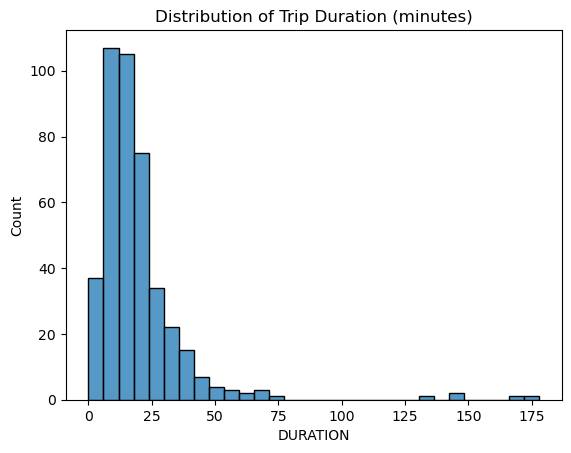

In [51]:
sns.histplot(data=dataset, x='DURATION', bins=30)
plt.title('Distribution of Trip Duration (minutes)')

# Conclusion: The graph shows that the rides lasted between 10- 25 mins.

# Histogram to show the distribution of trip miles

Text(0.5, 1.0, 'Distribution of Trip Miles')

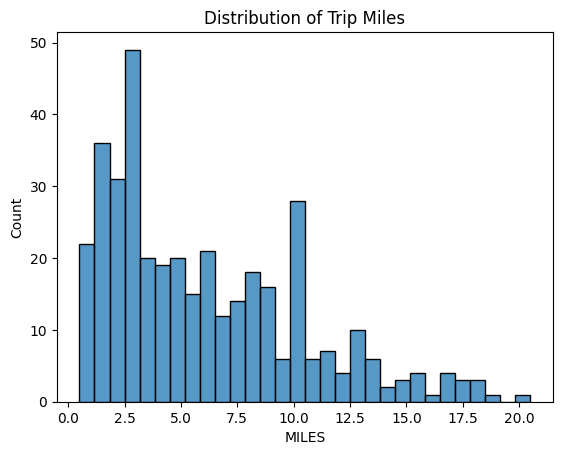

In [21]:
sns.histplot(data=df_clean, x='MILES', bins=30)
plt.title('Distribution of Trip Miles')

# Conclusion: The graph shows that most of the rides were very short, with the majority being less than 5 miles.

# Bar plot to display the Trip Catgory Distribution 

Text(0, 0.5, 'Count')

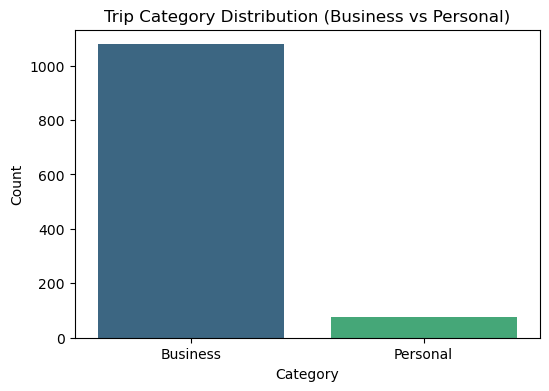

In [18]:
plt.figure(figsize=(6, 4))
category_counts = dataset['CATEGORY'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Trip Category Distribution (Business vs Personal)')
plt.xlabel('Category')
plt.ylabel('Count')

# Conclusion: The graph shows that the rides were for business purposes, with very few being for personal use.

# Bar plot for Distribution of Trip Purposes

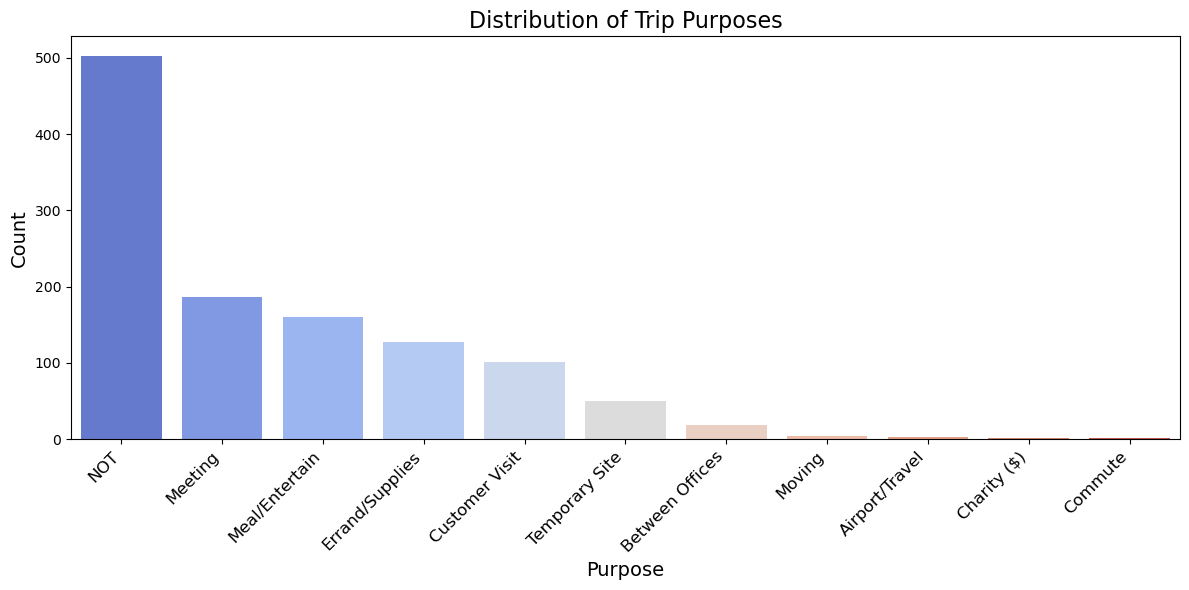

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
purpose_counts = dataset['PURPOSE'].value_counts()
sns.barplot(x=purpose_counts.index, y=purpose_counts.values, palette="coolwarm")
plt.title('Distribution of Trip Purposes', fontsize=16)
plt.xlabel('Purpose', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()


purpose_miles = dataset.groupby('PURPOSE')['MILES'].mean().sort_values(ascending=False).head()
sns.barplot(x=purpose_miles.index, y=purpose_miles.values)
plt.xticks(rotation=45)
plt.title('Average Miles by Top 5 Purposes')

# Conclusion: The graph shows that the most common purpose for rides is "Not Applicable/Unknown," followed by "Meeting" and "Meal/Entertain."

# Conclusion for Descriptive Analysis:



Based on the analysis:

1) Most trips (93%) are business-related.
2) Average trip is about 10.5 miles and 19 minutes
3) Top purposes are meetings, meals/entertainment, and errands
4) Trip distances range from 0.5 to 310.3 miles

# Diagonistic Analysis

# Which trip category has the highest average miles traveled, so Uber can consider category-specific promotions to encourage longer trips?

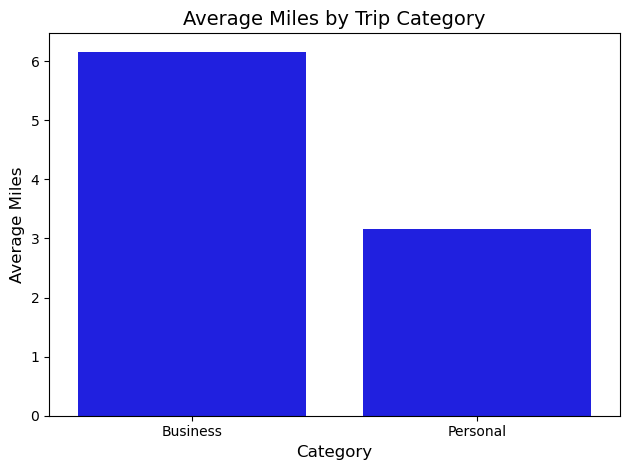

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.barplot(data=df_clean, x='CATEGORY', y='MILES', estimator='mean', errorbar=None, color='blue')
plt.title('Average Miles by Trip Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Miles', fontsize=12)
plt.tight_layout()
plt.show()

# What are the top purposes for which people travel the longest distances using Uber, so that targeted offers can be designed for these specific ride purposes?

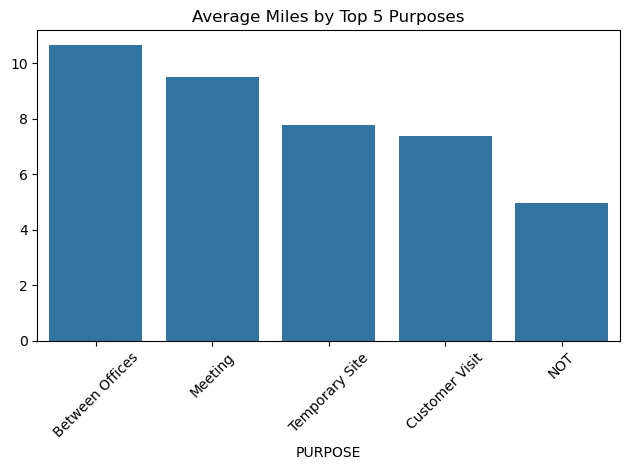

In [59]:
purpose_miles = df_clean.groupby('PURPOSE')['MILES'].mean().sort_values(ascending=False).head()
sns.barplot(x=purpose_miles.index, y=purpose_miles.values)
plt.xticks(rotation=45)
plt.title('Average Miles by Top 5 Purposes')
plt.tight_layout()
plt.show()

# Conclusion: The graph shows that commutes tend to be the longest rides in terms of mileage, followed by customer visits.

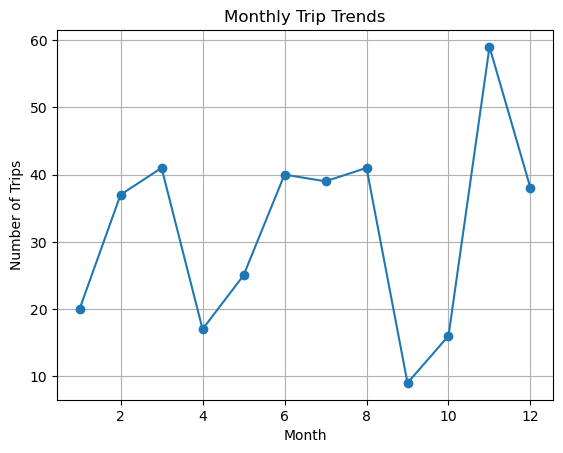

In [60]:
df_clean['month'] = df_clean['START_DATE'].dt.month
monthly_trips = df_clean.groupby('month').size()
monthly_trips.plot(kind='line', marker='o')
plt.title('Monthly Trip Trends')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

In [61]:
correlation_matrix = df_clean[['MILES', 'DURATION']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
             MILES  DURATION
MILES     1.000000  0.652815
DURATION  0.652815  1.000000


# Prescriptive Analysis

# Which hour of the day shows the highest average speed, and how can this information be used to optimize travel routes for better customer experience?

Key Recommendations:
Best travel times (highest speed): 15


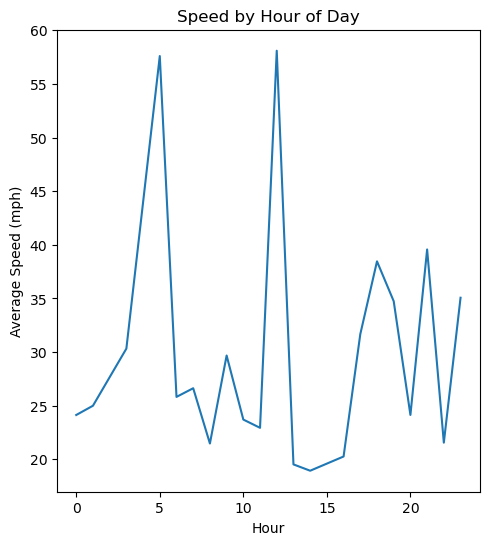

In [62]:
df_clean['speed'] = df_clean['MILES'] / (df_clean['DURATION']/60)  
df_clean['hour']=df_clean['START_DATE'].dt.hour
hourly_metrics = df_clean.groupby('hour').agg({
    'MILES': 'mean',
    'DURATION': 'mean',
    'speed': 'mean'
}).reset_index()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=hourly_metrics, x='hour', y='speed')
plt.title('Speed by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Speed (mph)')
print("\
Key Recommendations:")
print("Best travel times (highest speed):", hourly_metrics.loc[hourly_metrics['speed'].idxmax(), 'hour'])


# Which hours of the day experience the highest demand for Uber rides, and how can this data be used to optimize pricing strategies?

Average duration during high demand periods: 15.049668874172186 minutes
Suggested price increase during high demand periods: 20.0%


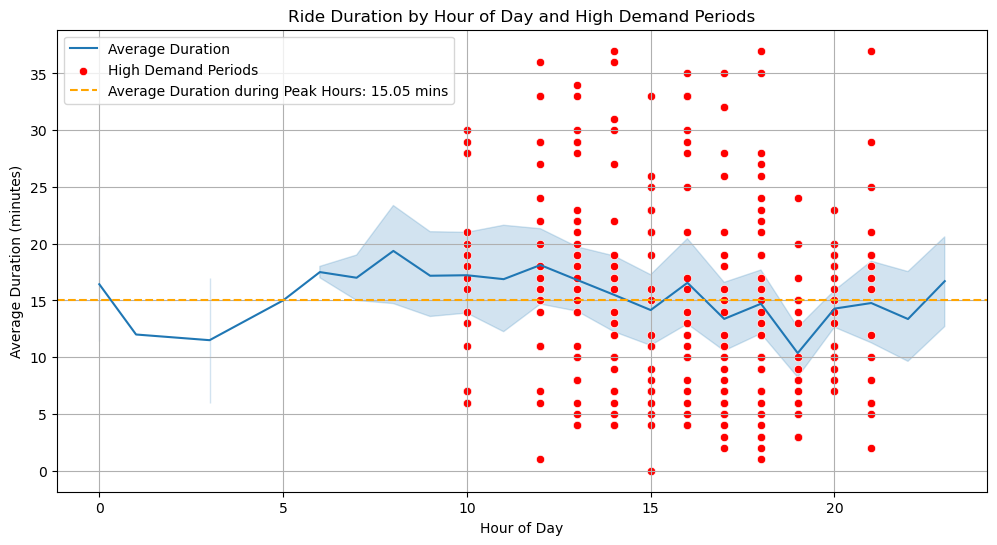

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
hourly_demand = df_clean.groupby('hour').size().reset_index(name='ride_count')
peak_hours = hourly_demand.loc[hourly_demand['ride_count'] > hourly_demand['ride_count'].median(), 'hour']
high_demand_periods = df_clean.loc[df_clean['hour'].isin(peak_hours), 'DURATION']
average_duration = high_demand_periods.mean()
print(f"Average duration during high demand periods: {average_duration} minutes")
price_increase = 0.2
print(f"Suggested price increase during high demand periods: {price_increase * 100}%")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_clean, x='hour', y='DURATION', estimator='mean', label='Average Duration')
sns.scatterplot(data=df_clean[df_clean['hour'].isin(peak_hours)], x='hour', y='DURATION', color='red', label='High Demand Periods')
plt.axhline(y=average_duration, color='orange', linestyle='--', label=f"Average Duration during Peak Hours: {average_duration:.2f} mins")
plt.title('Ride Duration by Hour of Day and High Demand Periods')
plt.xlabel('Hour of Day')
plt.ylabel('Average Duration (minutes)')
plt.legend()
plt.grid(True)
plt.show()


# Conclusion: This graph shows the average duration of rides by hour of day and highlights periods of high demand. It also indicates that the average duration during peak hours is approximately 15.05 minutes.

# Analysis Method: Time Series

In [64]:

df_clean.columns
if 'START_DATE' in df_clean.columns:
    df_clean['hour'] = df_clean['START_DATE'].dt.hour
    print("Hour column successfully extracted.")
else:
    print("'START_DATE' column is missing.")

Hour column successfully extracted.


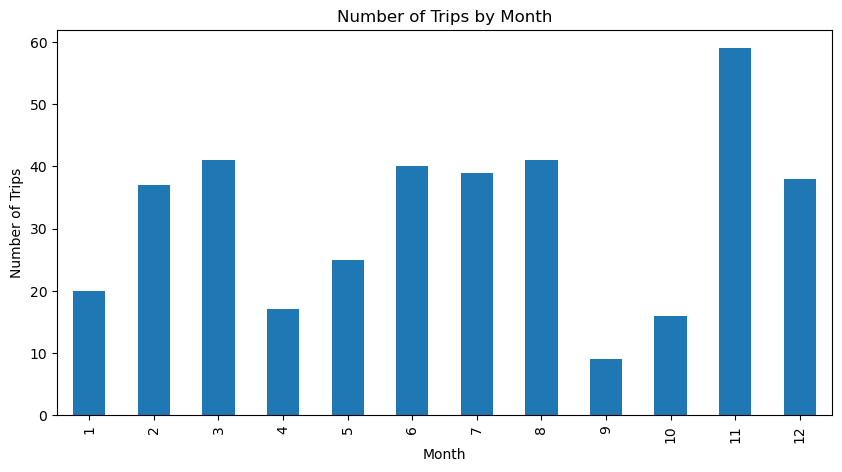

In [65]:
df_clean['month'] = df_clean['START_DATE'].dt.month
monthly_trips = df_clean.groupby('month').size()

plt.figure(figsize=(10, 5))
monthly_trips.plot(kind='bar')
plt.title('Number of Trips by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.show()

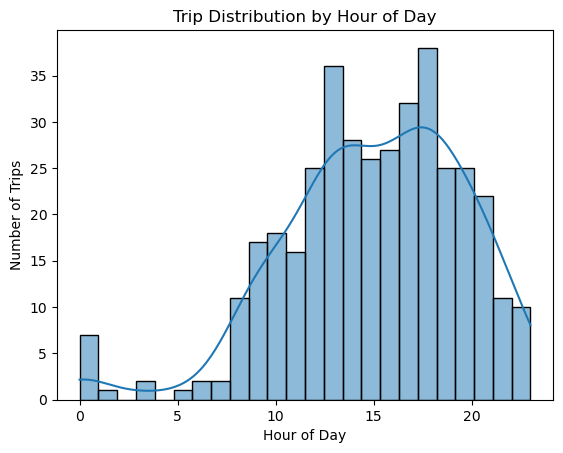

In [66]:
sns.histplot(data=df_clean, x='hour', bins=24, kde=True)
plt.title('Trip Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.show()

# Model Building : Linear Regression

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
X = df_clean[['MILES', 'hour', 'month']]
y = df_clean['DURATION']

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [70]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Model Performance:")
print("R2 Score:", round(rmse, 3))
print("RMSE:", round(r2, 3))


Model Performance:
R2 Score: 6.337
RMSE: 0.489


# Conclusion: 
1) An R2 score of 6.337 is generally considered quite good, indicating that the model explains 63.37% of the variance in the data. 
2) An RMSE of 0.489 is generally considered quite good, indicating that the model's predictions are relatively accurate. 

# How well does the model predict ride durations based on the scatter plot of actual vs predicted values?

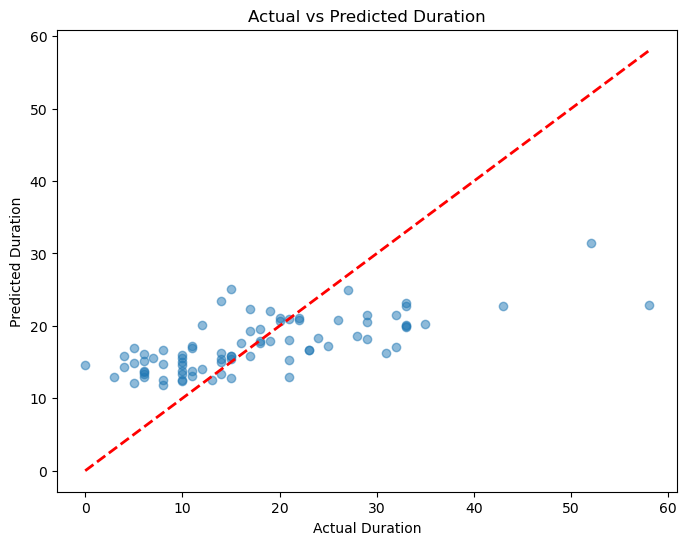

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.title('Actual vs Predicted Duration')
plt.show()

# New Data Prediction from the trained model

In [42]:
def predict_duration(new_data):
    new_data_df = pd.DataFrame(new_data, columns=['MILES', 'hour', 'month'])
    predictions = model.predict(new_data_df)
    for i, pred in enumerate(predictions):
        print(f"Prediction for data point {i+1}: {round(pred, 3)} minutes")
    return predictions
new_data = [
    {'MILES': 5, 'hour': 14, 'month': 7},
    {'MILES': 3, 'hour': 9, 'month': 1}
]
predict_duration(new_data)

Prediction for data point 1: 16.254 minutes
Prediction for data point 2: 17.428 minutes


array([16.25406302, 17.4279351 ])

# Conclusion: These predictions suggest that the model estimates the duration of the first ride to be approximately 16.254 minutes and the second ride to be approximately 17.428 minutes.